In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
matplotlib.__version__
#mpl_toolkits.mplot3d.__version__

'1.5.0'

In [4]:
sys.path.insert(0, '../cbcrom')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)

<module 'chebyshev' from '../cbcrom/chebyshev.pyc'>

In [5]:
#pyplot.rcParams.update(matplotlib.rcParamsDefault)

In [6]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

In [7]:
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in xrange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))


# Plot of Training Set and Reduced Bases

In [35]:
ts_filename = '../training_set_cheb_16/teob_runs_cheb_16_%d.hdf5'
memb_size=2**34-1
ts = tdwave.load_hdf5_time_domain_waveform_set(ts_filename, memb_size=memb_size)

In [36]:
memb_size=2**34-1

filename = '../data/teob_rbamp_smallq_cheb_16_%d.hdf5'
rbamp = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

filename = '../data/teob_rbphase_smallq_cheb_16_%d.hdf5'
rbphase = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

In [37]:
params = ts.get_parameter_grid()

In [38]:
ampparams = np.array(rbamp.get_parameters())
phaseparams = np.array(rbphase.get_parameters())

In [39]:
j=0
p = params.reshape(-1, 3)
rbphase_i = np.array([
        [i for i in range(len(p)) if np.array_equal(p[i], phaseparams[j])] 
        for j in range(len(phaseparams))
    ]).flatten()

In [42]:
x = params[:, :, 0, 0].flatten()
y = params[:, :, 0, 1].flatten()

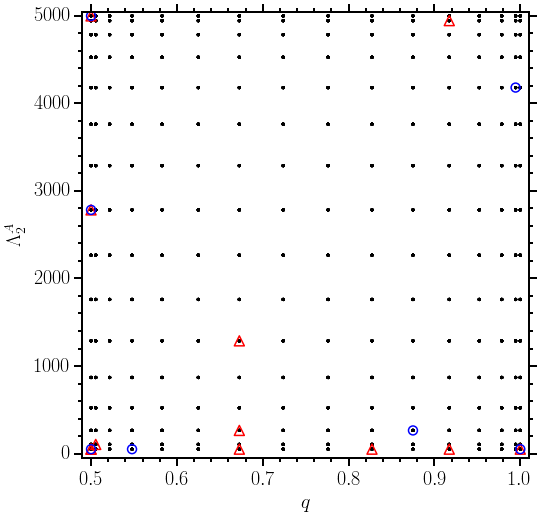

In [101]:
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111)
axes.scatter(x, y, edgecolor='none', marker='o', s=10, color='k')
axes.scatter(ampparams[:, 0], ampparams[:, 1], marker='^', s=100, facecolors='none', edgecolors='r', linewidth=1.5)
axes.scatter(phaseparams[:, 0], phaseparams[:, 1], marker='o', s=80, facecolors='none', edgecolors='b', linewidth=1.5)
axes.set_xlim([0.49, 1.01])
axes.set_ylim([-50, 5050])
axes.set_xlabel(r'$q$')
axes.set_ylabel(r'$\Lambda_2^A$')
axes.minorticks_on()
fig.savefig('/home/bdlackey/public_html/ROM/paramspace.pdf', 
            format='pdf', transparent=True, bbox_inches='tight')

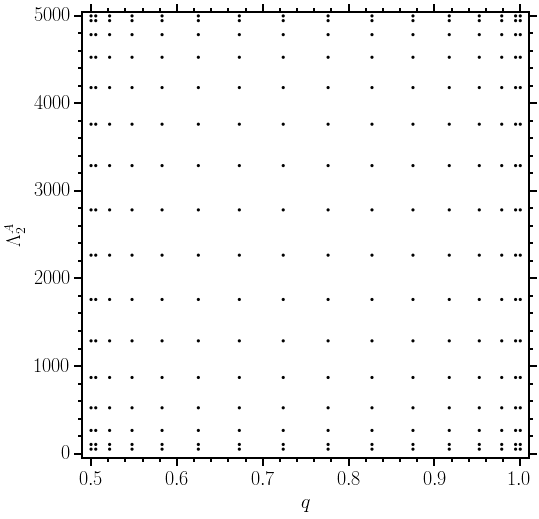

In [21]:
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111)
axes.scatter(x, y, edgecolor='none', marker='o', s=10, color='k')

axes.set_xlim([0.49, 1.01])
axes.set_ylim([-50, 5050])
axes.set_xlabel(r'$q$')
axes.set_ylabel(r'$\Lambda_2^A$')
axes.minorticks_on()

In [46]:
x = params[:, :, :, 0].flatten()
y = params[:, :, :, 1].flatten()
z = params[:, :, :, 2].flatten()

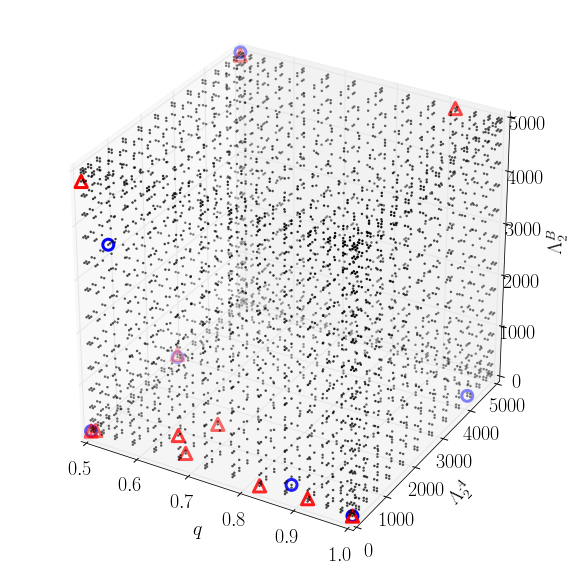

In [120]:
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(111, projection='3d')
#fig, axes = plt.subplots(1, projection='3d', figsize=(10, 10))

axes.scatter(x, y, z, c='k', edgecolor='none', marker='o', s=6)
#axes.scatter(ampparams[:, 0], ampparams[:, 1], ampparams[:, 2], marker='^', s=150, c='none', edgecolors='r', linewidth=3, depthshade=0)
#axes.scatter(phaseparams[:, 0], phaseparams[:, 1], phaseparams[:, 2], marker='o', s=120, c='none', edgecolors='b', linewidth=3, depthshade=0)
axes.scatter(ampparams[:, 0], ampparams[:, 1], ampparams[:, 2], marker='^', s=150, c='none', edgecolors='r', linewidth=3)
axes.scatter(phaseparams[:, 0], phaseparams[:, 1], phaseparams[:, 2], marker='o', s=120, c='none', edgecolors='b', linewidth=3)

axes.set_xlim(0.5, 1.0)
axes.set_ylim(0, 5000)
axes.set_zlim(0, 5000)
axes.set_xlabel(r'$q$', labelpad=10)
axes.set_ylabel(r'$\Lambda_2^A$', labelpad=15)
axes.set_zlabel(r'$\Lambda_2^B$', labelpad=18)
#axes.minorticks_on() #minor ticks not implemented yet in mplot3d 
#axes.dist = 10

fig.savefig('/home/bdlackey/public_html/ROM/paramspace3d.pdf', 
            format='pdf', transparent=True, bbox_inches='tight')

# Reduced Basis and empirical interpolant plots

In [14]:
memb_size=2**34-1

filename = '../data/teob_rbamp_smallq_cheb_16_%d.hdf5'
rbamp = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

filename = '../data/teob_rbphase_smallq_cheb_16_%d.hdf5'
rbphase = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

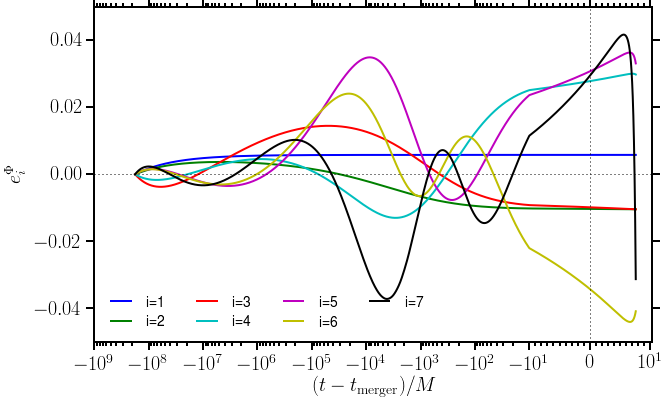

In [18]:
fig, axes = plt.subplots(1, figsize=(10, 6))

for j in range(rbphase.get_len()):
    h = rbphase.get_waveform_data(j)
    axes.plot(h.time, h.phase, lw=2, label='i='+str(j+1))

axes.axhline(0.0, color='k', ls=':')
axes.axvline(0.0, color='k', ls=':')

axes.set_xlim([-1.0e9, 11.0])
axes.set_ylim([-0.05, 0.05])
axes.set_xscale('symlog', linthreshx=10.0)
axes.xaxis.set_minor_locator(MinorSymLogLocator(10.0))
axes.set_xlabel(r'$(t-t_{\rm merger})/M$')
axes.set_ylabel(r'$e^\Phi_i$')
l = axes.legend(loc='lower left', ncol=4, frameon=False)
l.set_zorder(0)
fig.savefig('/home/bdlackey/public_html/ROM/RBphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

In [16]:
empirical_node_indices_amp, Bamp_j = tdrom.empirical_interpolation_for_time_domain_waveform(rbamp, 'amp')
empirical_node_indices_phase, Bphase_j = tdrom.empirical_interpolation_for_time_domain_waveform(rbphase, 'phase')

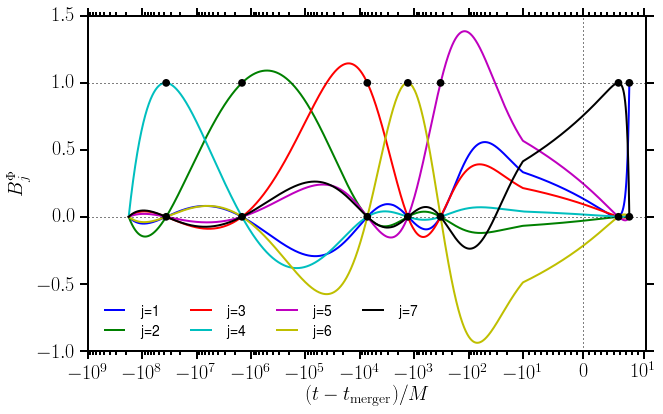

In [19]:
fig = plt.figure(figsize=(10, 6))
axes = fig.add_subplot(111)

for j in range(len(Bphase_j)):
    h = Bphase_j[j]
    axes.plot(h.time, h.phase, lw=2, label='j='+str(j+1))

htime = h.time[empirical_node_indices_phase]
# zorder is order in which figure is drawn (placed on top of previous figures)
axes.scatter(htime, 0*htime, marker='o', c='k', s=60, edgecolor='none', zorder=100)
axes.scatter(htime, 0*htime+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)
    
axes.axhline(y=0.0, color='k', ls=':')
axes.axhline(y=1.0, color='k', ls=':')
axes.axvline(0.0, color='k', ls=':')

axes.set_xlim([-1.0e9, 11.0])
axes.set_ylim([-1.0, 1.5])
axes.set_xscale('symlog', linthreshx=10.0)
axes.xaxis.set_minor_locator(MinorSymLogLocator(10.0))
axes.set_xlabel(r'$(t-t_{\rm merger})/M$')
axes.set_ylabel(r'$B^\Phi_j$')
l = axes.legend(loc='lower left', ncol=4, frameon=False)
l.set_zorder(0)
fig.savefig('/home/bdlackey/public_html/ROM/Bphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

# Histograms from Nested Sampling

In [8]:
def eta_of_q(q):
    """
    Takes either big Q=m_1/m_2 or little q=m_2/m_1 and returns
    symmetric mass ratio eta.
    """
    return q / (1.0 + q)**2

def big_and_small_q_of_eta(eta):
    bigq = (1.0-2.0*eta + np.sqrt(1.0-4.0*eta))/(2.0*eta)
    smallq = (1.0-2.0*eta - np.sqrt(1.0-4.0*eta))/(2.0*eta)
    
    return bigq, smallq

def m1_of_mchirp_eta(mchirp, eta):
    """
    m1 is always the more massive star (the primary)
    """
    return (1.0/2.0)*mchirp*eta**(-3.0/5.0) * (1.0 + np.sqrt(1.0-4.0*eta))


def m2_of_mchirp_eta(mchirp, eta):
    """
    m2 is always the less massive star (the secondary)
    """
    return (1.0/2.0)*mchirp*eta**(-3.0/5.0) * (1.0 - np.sqrt(1.0-4.0*eta))

def lamtilde_of_eta_lam1_lam2(eta, lam1, lam2):
    """
    $\tilde\Lambda(\eta, \Lambda_1, \Lambda_2)$. 
    Lambda_1 is assumed to correspond to the more massive (primary) star m_1.
    Lambda_2 is for the secondary star m_2.
    """
    return (8.0/13.0)*((1.0+7.0*eta-31.0*eta**2)*(lam1+lam2) + np.sqrt(1.0-4.0*eta)*(1.0+9.0*eta-11.0*eta**2)*(lam1-lam2))

def deltalamtilde_of_eta_lam1_lam2(eta, lam1, lam2):
    """
    This is the definition found in Les Wade's paper.
    Les has factored out the quantity \sqrt(1-4\eta). It is different from Marc Favata's paper.
    $\delta\tilde\Lambda(\eta, \Lambda_1, \Lambda_2)$. 
    Lambda_1 is assumed to correspond to the more massive (primary) star m_1.
    Lambda_2 is for the secondary star m_2.
    """
    return (1.0/2.0)*(
                      np.sqrt(1.0-4.0*eta)*(1.0 - 13272.0*eta/1319.0 + 8944.0*eta**2/1319.0)*(lam1+lam2)
                      + (1.0 - 15910.0*eta/1319.0 + 32850.0*eta**2/1319.0 + 3380.0*eta**3/1319.0)*(lam1-lam2)
                      )


In [20]:
import corner
samples = np.loadtxt('EOS_samples.dat')

In [31]:
m1_true, m2_true, lambda1_true, lambda2_true = 2.0, 1.4, 4813.3042, 3677.80591

eta_true = m1_true*m2_true / (m1_true+m2_true)**2
lamtilde_true = lamtilde_of_eta_lam1_lam2(eta_true, lambda1_true, lambda2_true)
dlamtilde_true = deltalamtilde_of_eta_lam1_lam2(eta_true, lambda1_true, lambda2_true)

In [21]:
mchirp = samples[:, 11]
q = samples[:, 31]
lambda1 = samples[:, 20]
lambda2 = samples[:, 21]

In [22]:
eta = eta_of_q(q)
m1 = m1_of_mchirp_eta(mchirp, eta)
m2 = m2_of_mchirp_eta(mchirp, eta)
lamtilde = lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
dlamtilde = deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)

In [ ]:
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")


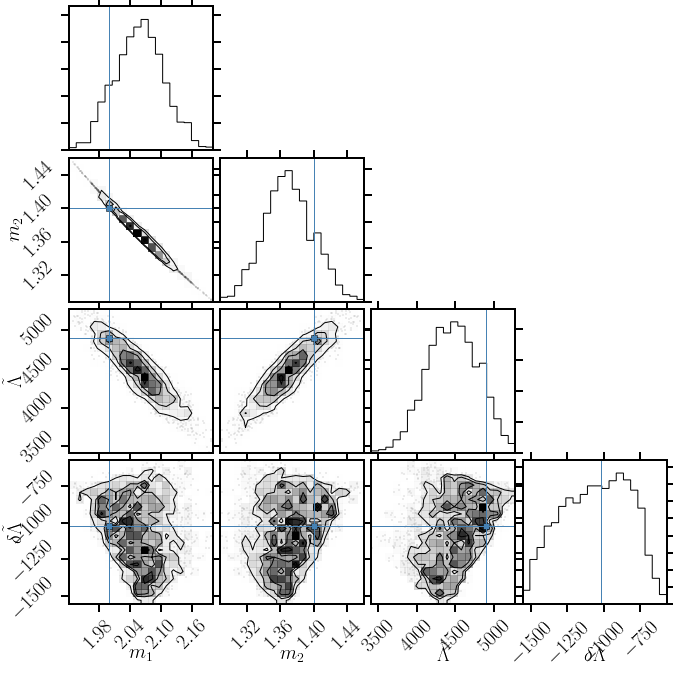

In [32]:
fig = corner.corner(np.array([m1, m2, lamtilde, dlamtilde]).T, 
                    labels=[r'$m_1$', r'$m_2$', r'$\tilde\Lambda$', r'$\delta\tilde\Lambda$'],
                   truths=[m1_true, m2_true, lamtilde_true, dlamtilde_true])

In [43]:
import scipy.ndimage.filters as filters # for Gaussian filter

def centered_histogram(samplesx, bins, histrange=None, density=False, smooth=False):
    """Takes a list of samples then bins them.
    Returns the 1d-histogram array, and
    1d array of the x-values centered on each bin.
    """
    
    # set histogram range if not given explicitly
    if histrange is None:
        histrange = [np.min(samplesx), np.max(samplesx)]
    
    hist, xedges = np.histogram(samplesx, bins=bins, range=histrange, density=density)
    
    # Gaussian smoothing
    if smooth:
        # Smooth the hist2d object with a Gaussian filter. Return values
        # at the same points and replace hist2d with those values.
        hist = filters.gaussian_filter(hist, sigma=0.75)

    # Delete the last point then shift the other points up half a bin to give the midpoint of each bin
    xcenters = np.delete(xedges, -1) + 0.5*(xedges[1] - xedges[0])

    return hist, xcenters

In [44]:
def confidence_plot(axes, samples, bins, histrange=None, smooth=False):
    """Draw confidence plot. Includes scatter plot of MCMC points, histogram of MCMC points, and confidence contours.
        """
    
    # set histogram range if not given explicitly
    if histrange is None:
        histrange = [np.min(samples), np.max(samples)]
    
    hist, centers = centered_histogram(samples, bins, histrange=histrange, density=False, smooth=smooth)
    #histrescale = MatchHistogramScale1D([hist])[0]
    
    axes.plot(centers, hist, c='k', ls='-', lw=2)

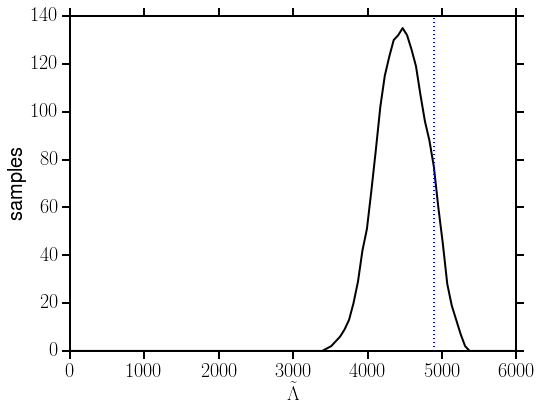

In [56]:
fig, axes = plt.subplots(figsize=(8, 6))
#confidence_plot(axes, lamtilde, 100, histrange=[0, 6000], smooth=False)
confidence_plot(axes, lamtilde, 100, histrange=[0, 6000], smooth=True)
axes.axvline(lamtilde_true, color='b', ls=':', lw=2)

#axes.set_xlim([-1.0e9, 11.0])
#axes.set_ylim([-1.0, 1.5])
axes.set_xlabel(r'$\tilde\Lambda$')
axes.set_ylabel('samples')

# Plots in sequence

In [208]:
import itertools

def ts_to_rb_plots(Nb):

    fig = plt.figure(figsize=(12, 12))
    
    colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
    axes = fig.add_axes([0.0, 0.55, 0.4, 0.4])
    for j in range(Nb):
        axes.scatter(phaseparams[j, 0], phaseparams[j, 1], marker='o', s=80, color=next(colors), edgecolors='none', linewidth=1.5)
        #axes.plot(phaseparams[j, 0], phaseparams[j, 1], 'o', markersize=80)
    axes.scatter(x, y, edgecolor='none', marker='o', s=10, color='k', zorder=0)
    axes.set_xlim([0.49, 1.01])
    axes.set_ylim([-50, 5050])
    axes.set_xlabel(r'$q$')
    axes.set_ylabel(r'$\Lambda_1$')
    axes.minorticks_on()
    
    
    axes = fig.add_axes([0.55, 0.6, 0.65, 0.3])
    for j in range(Nb):
        h = ts.get_waveform_data(rbphase_i[j])
        axes.plot(h.time, h.phase, lw=2, label='j='+str(j))
    
    axes.axhline(0.0, color='k', ls=':')
    axes.axvline(0.0, color='k', ls=':')
    
    axes.set_xlim([-1.0e9, 11.0])
    axes.set_ylim([0.0, 2.0e5])
    axes.set_xscale('symlog', linthreshx=10.0)
    axes.xaxis.set_minor_locator(MinorSymLogLocator(10.0))
    axes.set_xlabel(r'$(t-t_{\rm merger})/M$')
    axes.set_ylabel(r'Phase')
    axes.legend(loc='lower center', ncol=3)
    
    
    axes = fig.add_axes([0.2, 0.15, 0.65, 0.3])
    for j in range(Nb):
        h = rbphase.get_waveform_data(j)
        axes.plot(h.time, h.phase, lw=2, label='j='+str(j))
    
    axes.axhline(0.0, color='k', ls=':')
    axes.axvline(0.0, color='k', ls=':')
    
    axes.set_xlim([-1.0e9, 11.0])
    axes.set_ylim([-0.05, 0.05])
    axes.set_xscale('symlog', linthreshx=10.0)
    axes.xaxis.set_minor_locator(MinorSymLogLocator(10.0))
    axes.set_xlabel(r'$(t-t_{\rm merger})/M$')
    axes.set_ylabel(r'$\hat e^{\rm (Phase)}_j$')
    axes.legend(loc='lower center', ncol=3)

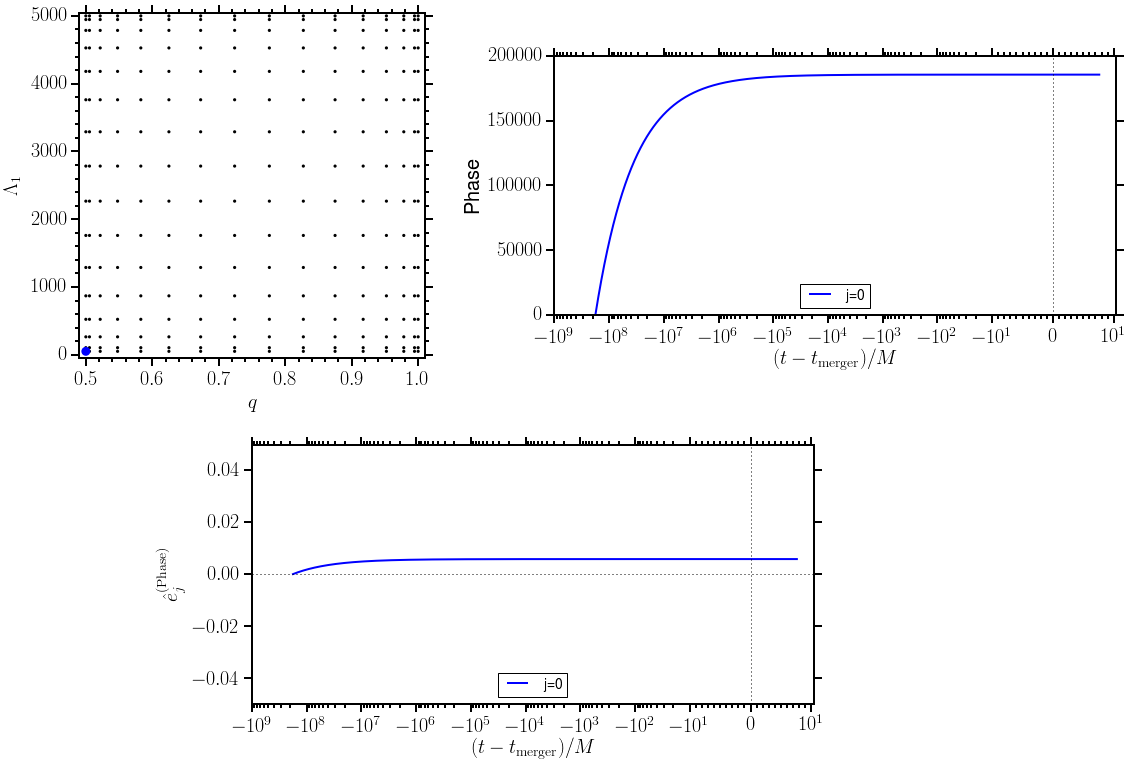

In [209]:
ts_to_rb_plots(1)

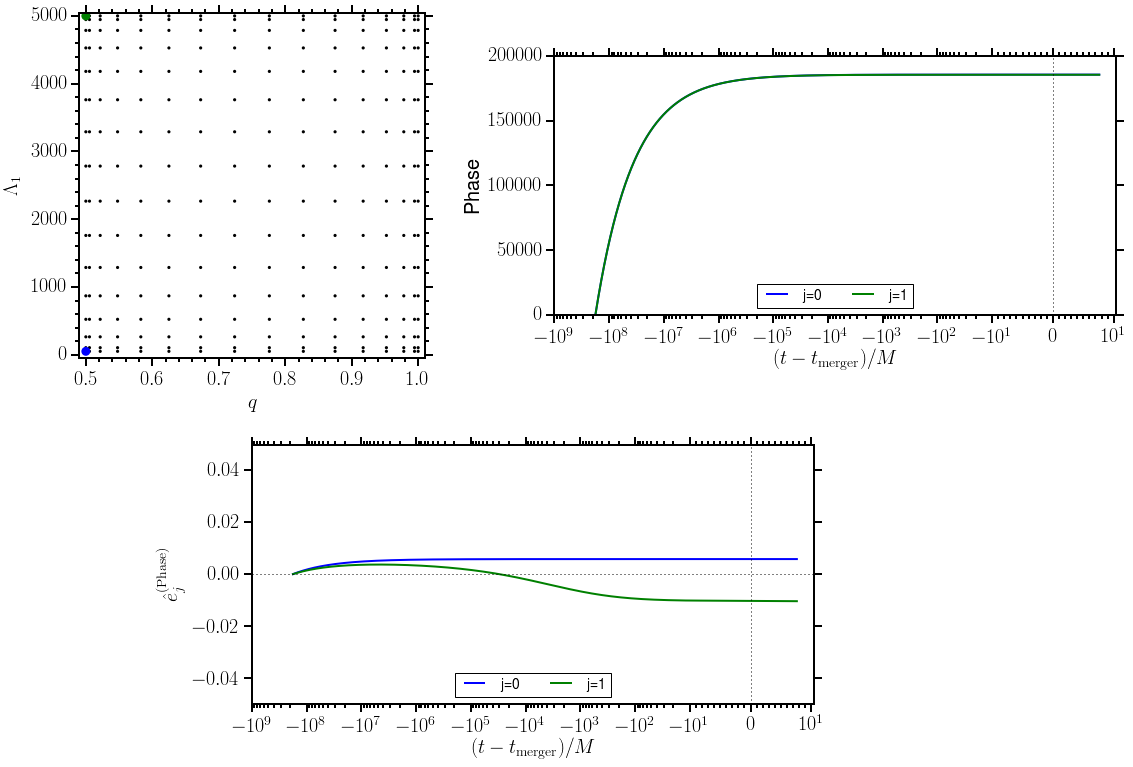

In [210]:
ts_to_rb_plots(2)

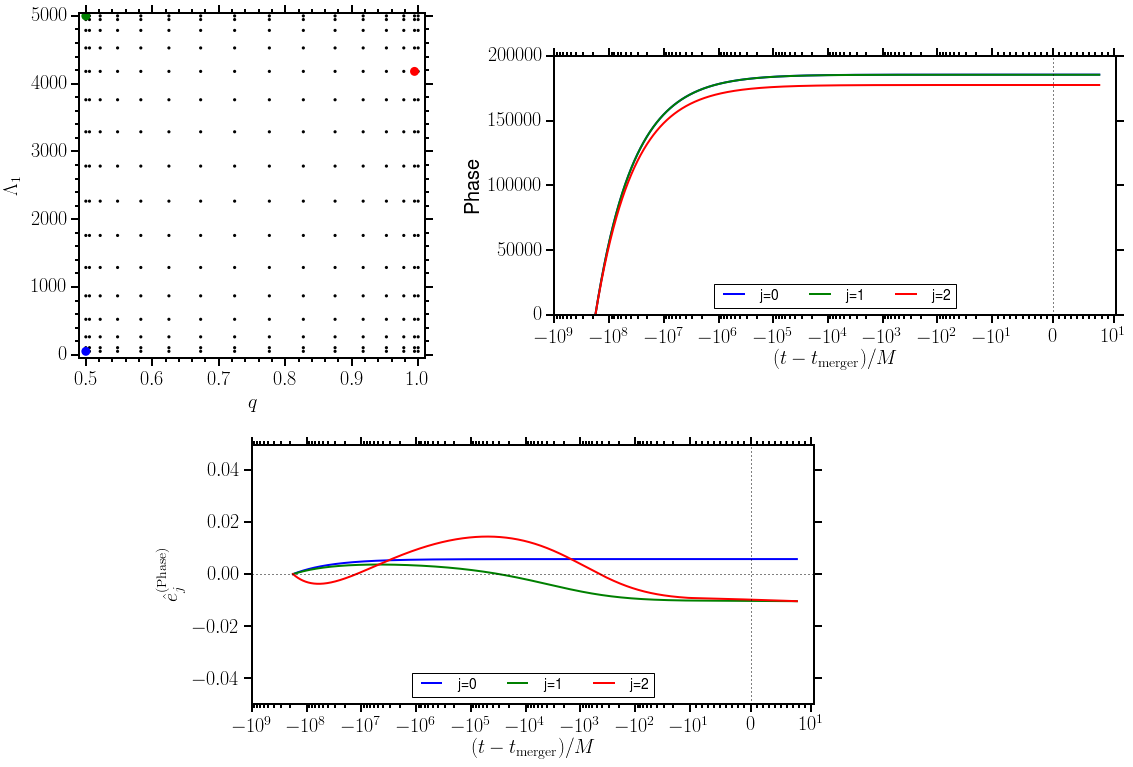

In [211]:
ts_to_rb_plots(3)

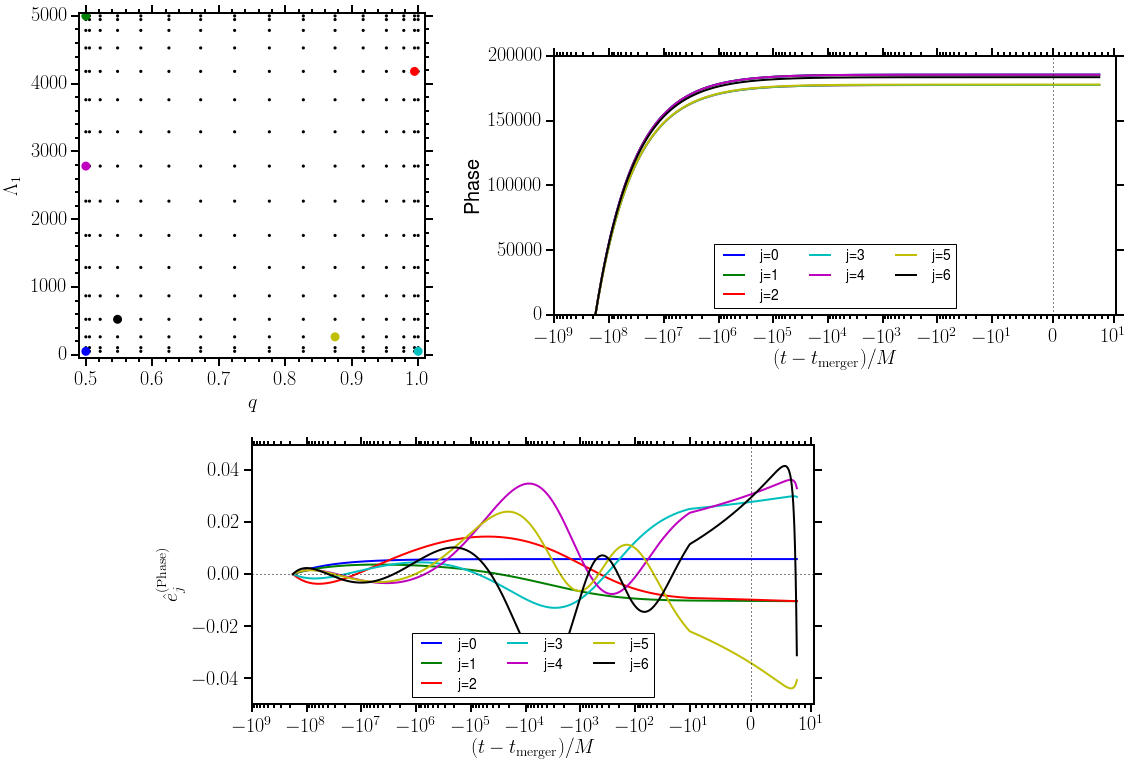

In [212]:
ts_to_rb_plots(7)

# Other

In [51]:
ampcoeff_filename = '../data/amp_coeffs.hdf5'
phasecoeff_filename = '../data/phase_coeffs.hdf5'

In [53]:
# Extract lists of coefficients for the interpolating functions(params)
amp_coeff_list, params_min, params_max = cheb.load_chebyshev_coefficients_list(ampcoeff_filename)
phase_coeff_list, params_min, params_max = cheb.load_chebyshev_coefficients_list(phasecoeff_filename)

# Generate the amplitude and phase functions(params)
amp_function_list = [cheb.chebyshev_interpolation3d_generator(amp_coeff_list[i], params_min, params_max) 
                     for i in range(len(amp_coeff_list))]
phase_function_list = [cheb.chebyshev_interpolation3d_generator(phase_coeff_list[i], params_min, params_max) 
                       for i in range(len(phase_coeff_list))]

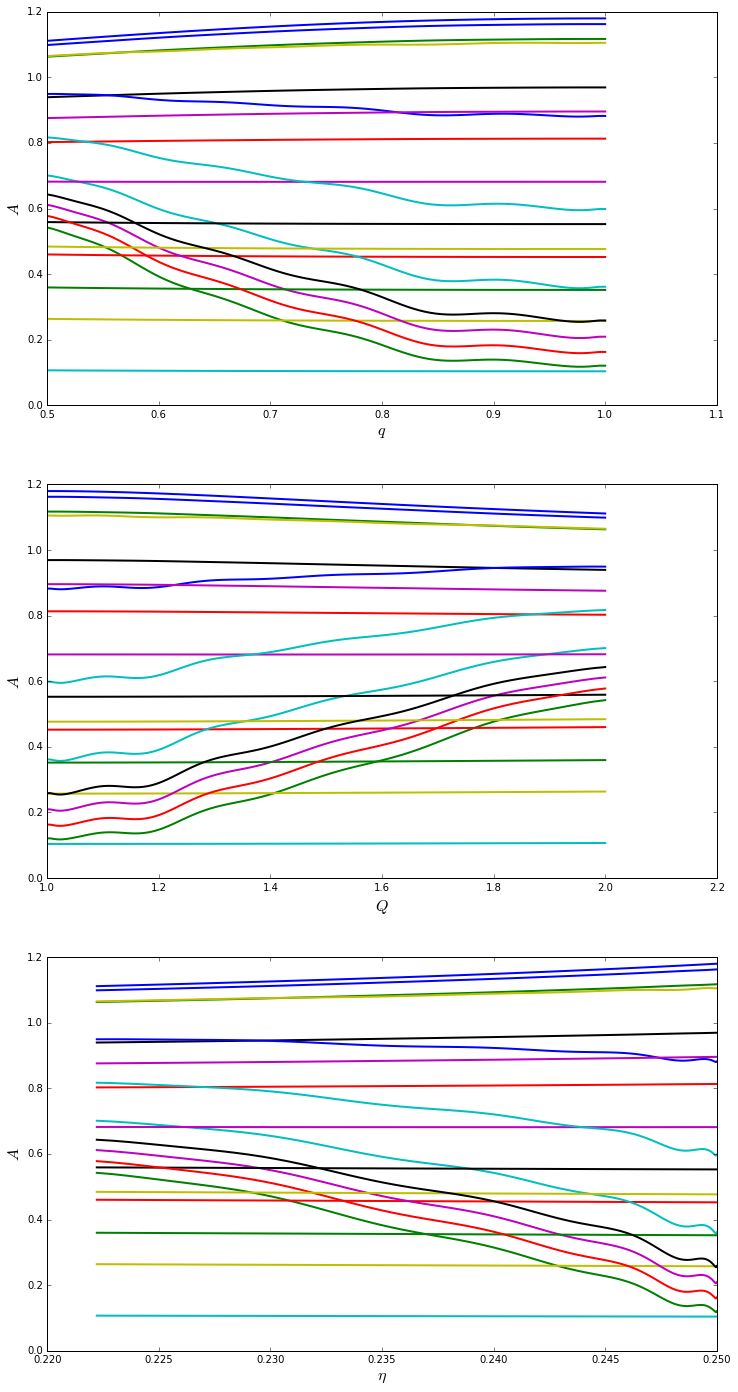

In [131]:
fig = plt.figure(figsize=(12, 24))

for i in range(len(amp_function_list)):
    lam1, lam2 = 50, 50
    qamp = np.array([[q, amp_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.5, 1.0, 100)])
    Qamp = np.array([[1.0/q, amp_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.5, 1.0, 100)])
    etaamp = np.array([[q/(1.0+q)**2, amp_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.5, 1.0, 100)])
    
    axes = fig.add_subplot(311)
    axes.plot(qamp[:, 0], qamp[:, 1], lw=2)
    #axes.set_xlim([10, 100.0])
    #axes.set_ylim([0.1, 100.0])
    axes.set_xlabel(r'$q$', fontsize=16)
    axes.set_ylabel(r'$A$', fontsize=16)
    #axes.legend(fontsize=14, loc='upper right', ncol=1)
    
    axes = fig.add_subplot(312)
    axes.plot(Qamp[:, 0], Qamp[:, 1], lw=2)
    #axes.set_xlim([10, 100.0])
    #axes.set_ylim([0.1, 100.0])
    axes.set_xlabel(r'$Q$', fontsize=16)
    axes.set_ylabel(r'$A$', fontsize=16)
    #axes.legend(fontsize=14, loc='upper right', ncol=1)
    
    axes = fig.add_subplot(313)
    axes.plot(etaamp[:, 0], etaamp[:, 1], lw=2)
    #axes.set_xlim([10, 100.0])
    #axes.set_ylim([0.1, 100.0])
    axes.set_xlabel(r'$\eta$', fontsize=16)
    axes.set_ylabel(r'$A$', fontsize=16)
    #axes.legend(fontsize=14, loc='upper right', ncol=1)

In [78]:
i=2
lam1, lam2 = 50, 50
qphase = np.array([[q, phase_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.5, 1.0, 100)])
Qphase = np.array([[1.0/q, phase_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.5, 1.0, 100)])
etaphase = np.array([[q/(1.0+q)**2, phase_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.5, 1.0, 100)])

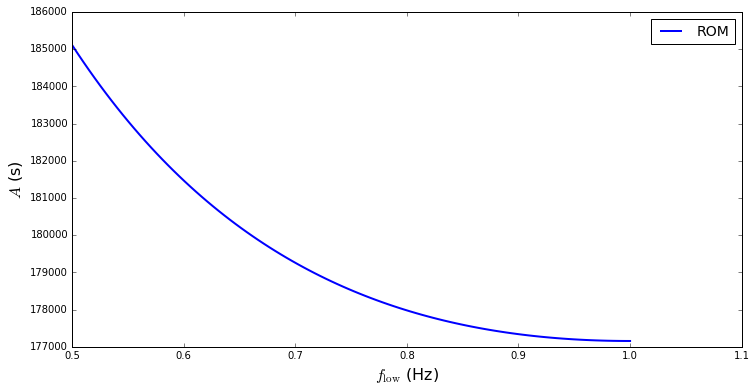

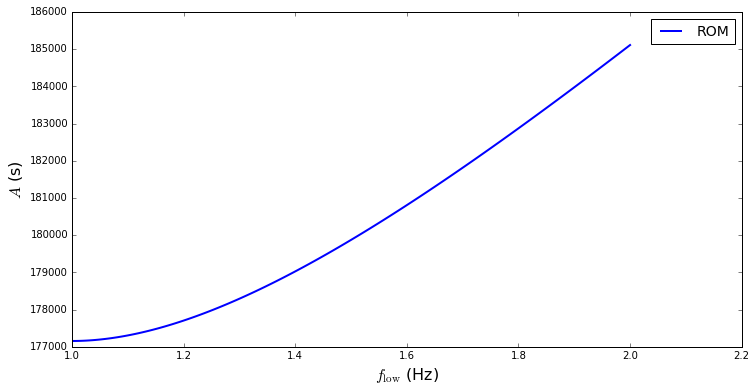

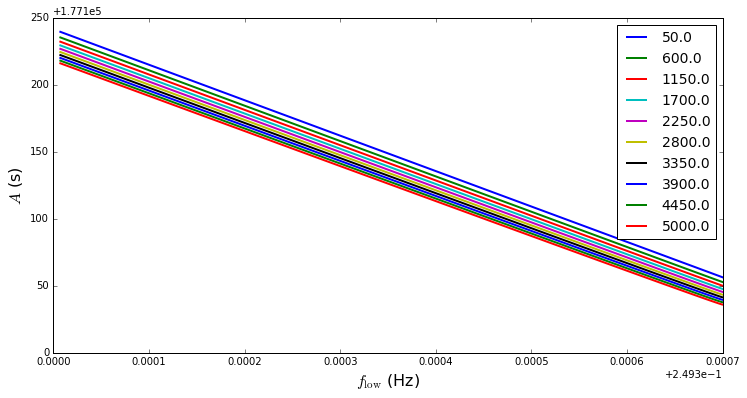

In [81]:
fig = plt.figure(figsize=(12, 6))
axes = fig.add_subplot(111)
axes.plot(qphase[:, 0], qphase[:, 1], lw=2, label='ROM')
#axes.set_xlim([10, 100.0])
#axes.set_ylim([0.1, 100.0])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)', fontsize=16)
axes.set_ylabel(r'$A$ (s)', fontsize=16)
axes.legend(fontsize=14, loc='upper right', ncol=1)

fig = plt.figure(figsize=(12, 6))
axes = fig.add_subplot(111)
axes.plot(Qphase[:, 0], Qphase[:, 1], lw=2, label='ROM')
#axes.set_xlim([10, 100.0])
#axes.set_ylim([0.1, 100.0])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)', fontsize=16)
axes.set_ylabel(r'$A$ (s)', fontsize=16)
axes.legend(fontsize=14, loc='upper right', ncol=1)


fig = plt.figure(figsize=(12, 6))
axes = fig.add_subplot(111)
for lam1 in np.linspace(50, 5000, 10):
    etaphase = np.array([[q/(1.0+q)**2, phase_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.9, 1.0, 100)])
    axes.plot(etaphase[:, 0], etaphase[:, 1], lw=2, label=str(lam1))
#axes.set_xlim([0.24, 0.25])
#axes.set_ylim([0.1, 100.0])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)', fontsize=16)
axes.set_ylabel(r'$A$ (s)', fontsize=16)
axes.legend(fontsize=14, loc='upper right', ncol=1)

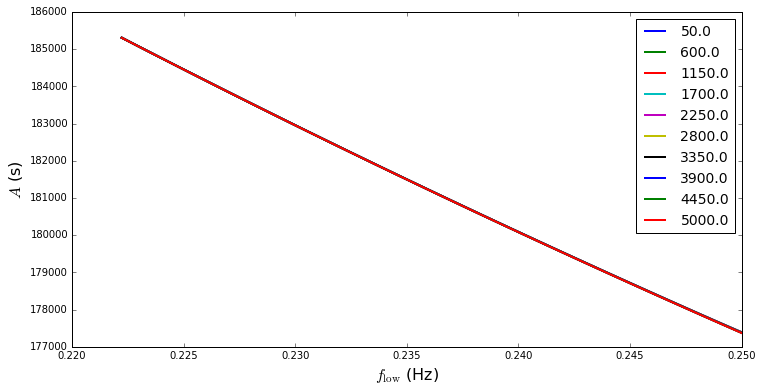

In [91]:
i=6
lam1 = 5000
fig = plt.figure(figsize=(12, 6))
axes = fig.add_subplot(111)
for lam2 in np.linspace(50, 5000, 10):
    etaphase = np.array([[q/(1.0+q)**2, phase_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.5, 1.0, 100)])
    axes.plot(etaphase[:, 0], etaphase[:, 1], lw=2, label=str(lam2))
#axes.set_xlim([0.24, 0.25])
#axes.set_ylim([0.1, 100.0])
axes.set_xlabel(r'$f_{\rm low}$ (Hz)', fontsize=16)
axes.set_ylabel(r'$A$ (s)', fontsize=16)
axes.legend(fontsize=14, loc='upper right', ncol=1)

In [ ]:

fig = plt.figure(figsize=(12, 6))
axes = fig.add_subplot(111)
etaphase = np.array([[q/(1.0+q)**2, phase_function_list[i]([q, lam1, lam2])] for q in np.linspace(0.9, 1.0, 100)])
axes.plot(etaphase[:, 0], etaphase[:, 1], lw=2)

In [3]:
memb_size=2**26-1
Bamp_filename = '../data/Bamp_%d.hdf5'
Bphase_filename = '../data/Bphase_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs.hdf5'
phasecoeff_filename = '../data/phase_coeffs.hdf5'
rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)